In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import os

kaggle = True
PRE_PATH = '/kaggle/input/classify-leaves' if kaggle else ''

train, test = os.path.join(PRE_PATH, 'train.csv'), os.path.join(PRE_PATH, 'test.csv')
train_val_df, test_df = pd.read_csv(train), pd.read_csv(test)
num_output = train_val_df.label.unique().size

In [2]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_val_df['label'] = le.fit_transform(train_val_df['label'])
train_val_df.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,image,label
0,images/0.jpg,78
1,images/1.jpg,78
2,images/2.jpg,78
3,images/3.jpg,78
4,images/4.jpg,78


In [3]:
# load resnet50 model from pytorch
import torch
import torchvision.models as models
import torch.nn as nn
model = models.resnet50(pretrained=True)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# load the model to GPU
device = torch.device('cuda')

# replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(2048, num_output, device=device)

model = model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s] 


In [15]:
# train model
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.io import read_image
import numpy as np
import time

# define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# define dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        self.train = bool('label' in df)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(PRE_PATH, row['image']))
        label = torch.tensor(row['label']) if self.train else torch.tensor(-1)
        
        if self.transforms:
            img = self.transforms(img)
            
        return img.to(device), label

# create dataset objects
offset = train_val_df.shape[0] // 10
train_df, val_df = train_val_df.iloc[offset:], train_val_df.iloc[:offset]

train_dataset = Dataset(train_df, train_transforms)
val_dataset = Dataset(val_df, test_transforms)
test_dataset = Dataset(test_df, test_transforms)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
!pip install d2l

  Obtaining dependency information for d2l from https://files.pythonhosted.org/packages/8b/39/418ef003ed7ec0f2a071e24ec3f58c7b1f179ef44bec5224dcca276876e3/d2l-1.0.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 70.4 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for matplotlib==3.7.2 from https://files.pythonhosted.org/packages/c2/da/a5622266952ab05dc3995d77689cba600e49ea9d6c51d469c077695cb719/matplotlib-3.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 41.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 81.2 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: scipy
    Found existing ins

loss 0.009, train acc 0.713, test acc 0.663
669.3 examples/sec on [device(type='cuda', index=0)]


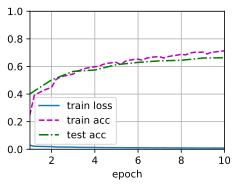

In [9]:
import d2l.torch as d2l

d2l.train_ch13(model, train_loader, valid_loader, criterion, optimizer, 10)

In [11]:
torch.save(model.state_dict(), os.path.join('/kaggle/working/', "model.pth"))


In [32]:
model.eval()

results = []
for images, _ in test_loader:
    res = model(images)
    encoded_res = torch.argmax(res, dim=1)
    results.append(encoded_res)

# Concatenate all the results
results = torch.cat(results)

# Move the results to cpu and convert to numpy array
results = results.cpu().numpy()

# Decode the results
real_res = le.inverse_transform(results)


KeyError: 'id'

In [34]:

# Create the submission dataframe
submission_df = pd.DataFrame({
    'image': test_df['image'],
    'label': real_res
})

submission_df.to_csv('/kaggle/working/submission.csv', index=False)